In [31]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from pyhive import trino
import pydeck as pdk
from typing import List
import json
import copy
import itertools
# import geohash
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import box
import geopandas as geopd
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from h3 import h3
import seaborn as sns
import folium
from keplergl import KeplerGl
from datetime import datetime, timedelta

import math
import pickle

os.environ['MAPBOX_API_KEY'] = "INSERT YOUR MAPBOX TOKEN HERE"
pd.set_option('display.max_colwidth', 0)

In [32]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [36]:
geography_table = "cuebiq.paas_cda_pe_v3.geography_registry"
# Census Block Groups typically have a population between 600 to 3000 people, this makes the data privacy safe.
hw_table = "cuebiq.paas_cda_pe_v3.device_recurring_area"
date = 20220310 # Thursday
date_formated = datetime.strptime(str(date), "%Y%m%d").strftime("%Y-%m-%d")
stop_table = "dedicated.rsu.la_stop_uplevelled"
visit_table = "cuebiq.paas_cda_pe_v3.visit"
date_plus = int((datetime.strptime(str(date), "%Y%m%d") + timedelta(days=3)).strftime("%Y%m%d"))# You see that we can limit to the first three processing dates starting from the local date of interest.

# census_data_table = "cuebiq.paas_public_data.census_data"
# census_taxonomy_table = "cuebiq.paas_public_data.census_taxonomy"

taxonomy_table = "cuebiq.paas_cda_pe_v3.segment_taxonomy"
user_labeling_table = "cuebiq.paas_cda_pe_v3.device_user_labeling"

In [77]:
# %%time
# # read LA CBG data
# cbg_geom = sql_engine.read_sql(
#     f"""
#     select
#         *
#     from {geography_table}
#     where
#         country_code = 'US'
#         and geography_type_code = 'admin4'
#         and geography_id like 'US.CA.037%'     --- <<< filter geometries in LA
#     """
# )

# cbg_geom.rename(columns={'geography_id': 'block_group_id', 'geometry_wkt': 'geom'}, inplace=True)
# # eliminate Catalina island and another island in the south of Catalina island
# cbg_geom = cbg_geom[~cbg_geom['block_group_id'].isin(['US.CA.037.599100.2','US.CA.037.599000.2','US.CA.037.599000.1','US.CA.037.599000.4','US.CA.037.599000.3','US.CA.037.599100.1'])]

In [37]:
df_visit_LA_hourly_entropy_shp = pd.read_pickle("./output/weighted_LA_11_13_visit_diversity.pkl")  
print(df_visit_LA_hourly_entropy_shp.shape[0])
df_visit_LA_hourly_entropy_shp.head(1)

3340


,block_group_id,R_White,R_HispanicLatinx,R_AfricanAmerican,R_AmericanIndianAlaska,R_Asian,R_Other,weighted_devices,scaled_entropy,class,...,"c_Finance, Insurance and Real Estate",c_Manufacturing,c_NA,c_Public Administration,c_Retail Trade,c_Services,"c_Transportation, Communications, Electric, Gas and Sanitary service",c_Wholesale Trade,geom,category
0,US.CA.037.101110.2,0.439024,0.262873,0.001355,0.0,0.220867,0.075881,29.52,0.69808,moderate diversity,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"POLYGON ((-118.291044 34.255927, -118.29132400000002 34.259555000000006, -118.300753 34.259609, -118.30082399999999 34.25872, -118.302291 34.258697, -118.29945100000002 34.255978, -118.291044 34.255927))",R_White_moderate diversity


# Sociodemographic

In [ ]:
# %%time
# user_profile = sql_engine.read_sql(
#     f"""
#     select * 
#     from {user_labeling_table}
#     where 
#         reference_date = 20210811
#     limit 10
#     """
# )

# Read walkability data

In [38]:
df_walk = pd.read_csv('./data/LA_walk.csv', header=0, sep=',')
df_walk['block_group_id'] = 'US.CA.037.' + df_walk['TRACTCE'].astype(str) + '.' +  df_walk['BLKGRPCE'].astype(str) 
print(df_walk.shape[0])
# df_walk.head(2)

6419


In [39]:
df_walk['NatWalkInd_nor'] = (df_walk['NatWalkInd'] - df_walk['NatWalkInd'].min()) / (df_walk['NatWalkInd'].max() - df_walk['NatWalkInd'].min())
df_walk['NatWalkInd_nor'].describe()
# df_walk.NatWalkInd.min()

count    6419.000000
mean     0.662059   
std      0.165405   
min      0.000000   
25%      0.578947   
50%      0.684211   
75%      0.780702   
max      1.000000   
Name: NatWalkInd_nor, dtype: float64

# Merge with diversity index

3340


<AxesSubplot: >

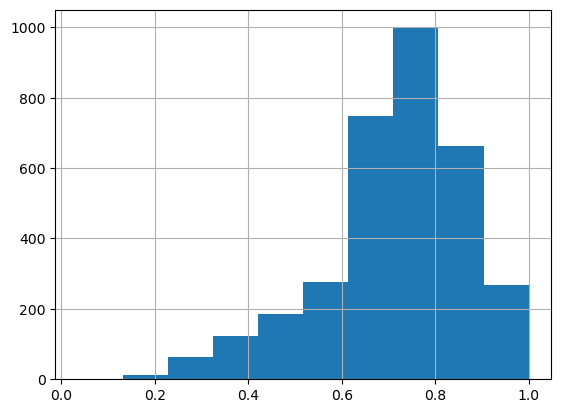

In [40]:
df_visit_LA_walk = pd.merge(df_visit_LA_hourly_entropy_shp,df_walk[['block_group_id','NatWalkInd_nor']],on='block_group_id')  
# df_visit_LA_walk.head(5)
print(df_visit_LA_walk.shape[0])
df_visit_LA_walk['NatWalkInd_nor'].hist()

count    3340.000000
mean     0.387727   
std      0.339083   
min      0.000000   
25%      0.071994   
50%      0.331708   
75%      0.588956   
max      1.000000   
Name: c_Retail Trade, dtype: float64


<AxesSubplot: >

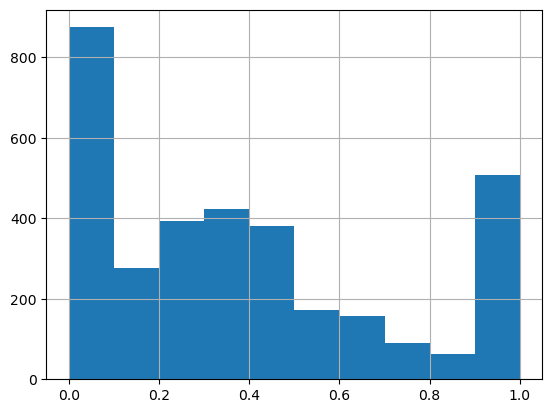

In [41]:
# df_visit_LA_walk
print(df_visit_LA_walk['c_Retail Trade'].describe())
df_visit_LA_walk['c_Retail Trade'].hist()

In [42]:
from scipy.stats import pearsonr

corr, pval = pearsonr(df_visit_LA_walk['scaled_entropy'], df_visit_LA_walk['NatWalkInd_nor'])

# view the correlation coefficient and p-value
print("Correlation Coefficient:", corr)
print("P-value:", pval)

Correlation Coefficient: 0.004662037648229837
P-value: 0.7876738180433259


In [43]:
import geopandas as gpd

df_visit_LA_walk['geom'] = gpd.GeoSeries.from_wkt(df_visit_LA_walk['geom'])
gdf_LA = gpd.GeoDataFrame(df_visit_LA_walk, geometry=df_visit_LA_walk['geom'])
gdf_LA.drop(['geom'], inplace=True, axis=1)
gdf_LA = gdf_LA.set_crs('epsg:4326')
gdf_LA = gdf_LA.to_crs(3857)

<AxesSubplot: >

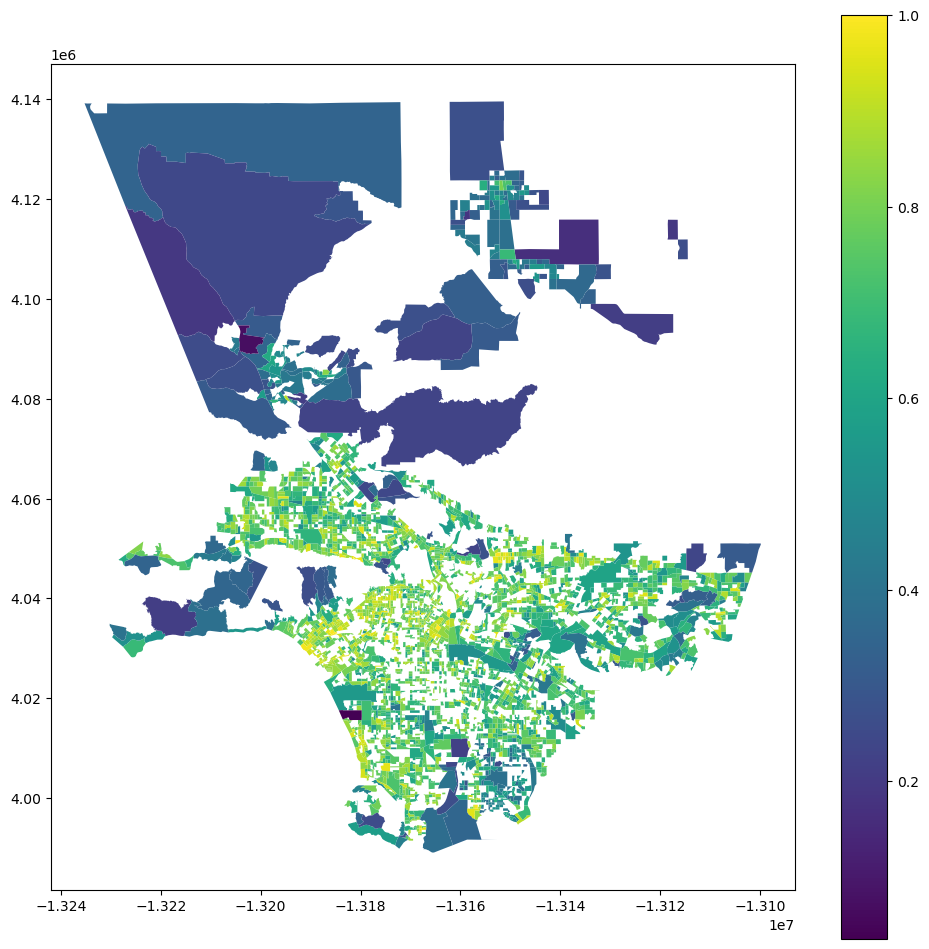

In [44]:
fig, ax = plt.subplots(figsize=(12,12))
gdf_LA.plot(column='NatWalkInd_nor', ax=ax, legend=True)

# GWR

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

In [46]:
gdf_LA.columns

Index(['block_group_id', 'R_White', 'R_HispanicLatinx', 'R_AfricanAmerican',
       'R_AmericanIndianAlaska', 'R_Asian', 'R_Other', 'weighted_devices',
       'scaled_entropy', 'class', 'dominant_race',
       'class_dominantclass_dominant', 'c_Agriculture, Forestry and Fishing',
       'c_Finance, Insurance and Real Estate', 'c_Manufacturing', 'c_NA',
       'c_Public Administration', 'c_Retail Trade', 'c_Services',
       'c_Transportation, Communications, Electric, Gas and Sanitary service',
       'c_Wholesale Trade', 'category', 'NatWalkInd_nor', 'geometry'],
      dtype='object')

In [47]:
g_y = gdf_LA['scaled_entropy'].values.reshape((-1,1))
g_X = gdf_LA[['NatWalkInd_nor','c_Finance, Insurance and Real Estate', 'c_Retail Trade', 'c_Services',
              'c_Transportation, Communications, Electric, Gas and Sanitary service','c_Wholesale Trade']].values
print(g_X.shape)
g_coords = list(zip(gdf_LA.centroid.x,gdf_LA.centroid.y))
print(g_coords[:5])

(3340, 6)
[(-13168655.5593864, 4063472.0712453644), (-13167820.212489897, 4062602.8178665885), (-13167047.166462636, 4062377.1589308665), (-13165843.366990121, 4062931.4080309873), (-13165767.2030553, 4060888.0715435147)]


In [48]:
%%time
#Calibrate GWR model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

205.0
CPU times: user 3min 21s, sys: 3min 11s, total: 6min 33s
Wall time: 3min 16s


In [49]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3340
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             99.209
Log-likelihood:                                                    1133.303
AIC:                                                              -2252.606
AICc:                                                             -2250.563
BIC:                                                             -26943.840
R2:                                                                   0.016
Adj. R2:                                                              0.014

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [16]:
# %%time
# #Calibrate MGWR model: *** seems need to take 4h to run

# mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
# mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
# print(mgwr_bw)
# mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()


In [57]:
# mgwr_results.summary()

## Mapping

In [50]:
#'NatWalkInd_nor','c_Finance, Insurance and Real Estate', 'c_Retail Trade', 'c_Services',
#              'c_Transportation, Communications, Electric, Gas and Sanitary service','c_Wholesale Trade'
gdf_LA['gwr_x0'] = gwr_results.params[:,0]
gdf_LA['gwr_x1_walk'] = gwr_results.params[:,1]
gdf_LA['gwr_x2_finance'] = gwr_results.params[:,2]
gdf_LA['gwr_x3_retail'] = gwr_results.params[:,3]
gdf_LA['gwr_x4_service'] = gwr_results.params[:,4]
gdf_LA['gwr_x5_transportation'] = gwr_results.params[:,5]
gdf_LA['gwr_x6_wholesale'] = gwr_results.params[:,6]


gwr_filtered_t = gwr_results.filter_tvals()
gdf_LA['gwr_t_walk'] = gwr_filtered_t[:,1]
gdf_LA['gwr_t_finance'] = gwr_filtered_t[:,2]
gdf_LA['gwr_t_retail'] = gwr_filtered_t[:,3]
gdf_LA['gwr_t_service'] = gwr_filtered_t[:,4]
gdf_LA['gwr_t_transportation'] = gwr_filtered_t[:,5]
gdf_LA['gwr_t_wholesale'] = gwr_filtered_t[:,6]

In [51]:
gdf_LA.to_pickle("./output/GWR_weighted_LA_11_13.pkl")  

In [7]:
gdf_LA = pd.read_pickle("./output/GWR_weighted_LA_11_13.pkl")  

In [33]:
# gdf_LA['mgwr_x0'] = mgwr_results.params[:,0]
# gdf_LA['mgwr_x1'] = mgwr_results.params[:,1]
# mgwr_filtered_t = mgwr_results.filter_tvals()

/tmp/ipykernel_181/3526098162.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


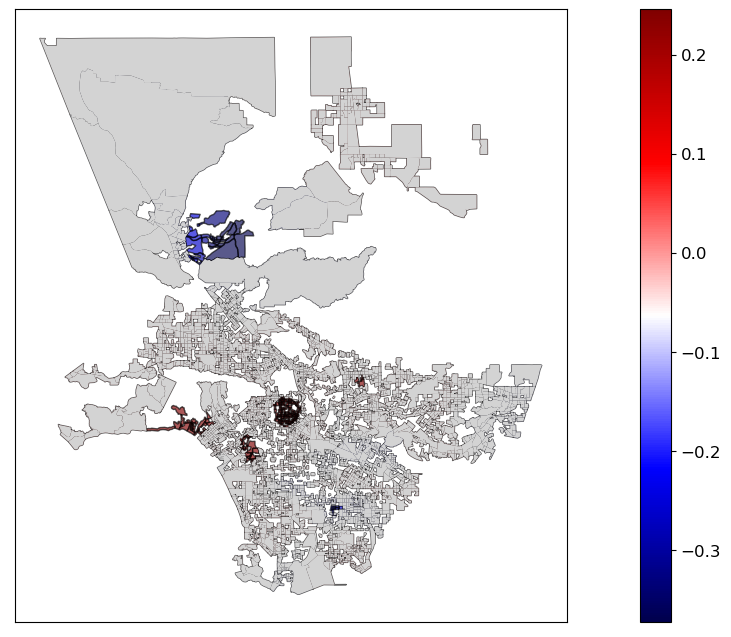

In [52]:
var1,t1 = 'gwr_x1_walk','gwr_t_walk'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
# # ax.set_title('walk index (BW: ' + str(gwr_bw) +')', fontsize=12)

# #Set color map
# cmap = plt.cm.seismic

# #Find min and max values of the combined dataset
# gwr_min = gdf_LA[var1].min()
# gwr_max = gdf_LA[var1].max()
# vmin = np.min([gwr_min])
# vmax = np.max([gwr_max])

# #If all values are negative use the negative half of the colormap
# if (vmin < 0) & (vmax < 0):
#     cmap = truncate_colormap(cmap, 0.0, 0.5)
# #If all values are positive use the positive half of the colormap
# elif (vmin > 0) & (vmax > 0):
#     cmap = truncate_colormap(cmap, 0.5, 1.0)
# #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
# else:
#     cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
gdf_LA.plot(var1, cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#If there are insignificnt parameters plot gray polygons over them
if (gdf_LA[t1] == 0).any():
    gdf_LA[gdf_LA[t1] == 0].plot(color='lightgrey', ax=ax)

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [53]:
positive = gdf_LA[(gdf_LA[var1]>0)&(gdf_LA[t1]!=0)]
print(positive.shape[0])
# positive[['block_group_id','gwr_x1','gwr_t']]

181


/tmp/ipykernel_181/1114189313.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


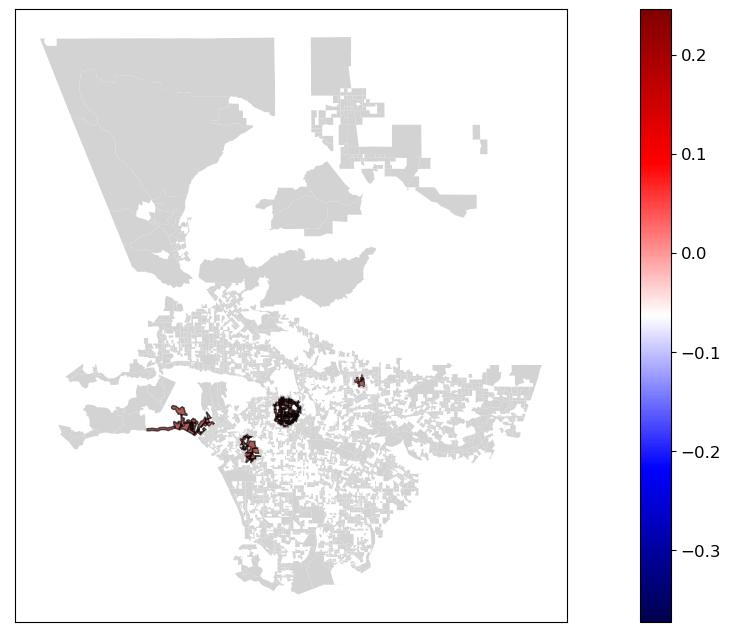

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
positive.plot(var1, cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#If there are insignificnt parameters plot gray polygons over them
if (gdf_LA[t1] == 0).any():
    gdf_LA[gdf_LA[t1] == 0].plot(color='lightgrey', ax=ax)

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
negative = gdf_LA[(gdf_LA[var1]<0)&(gdf_LA[t1]!=0)]
print(negative.shape[0])
# negative[['block_group_id','gwr_x1','gwr_t']]

123


/tmp/ipykernel_181/3075645919.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


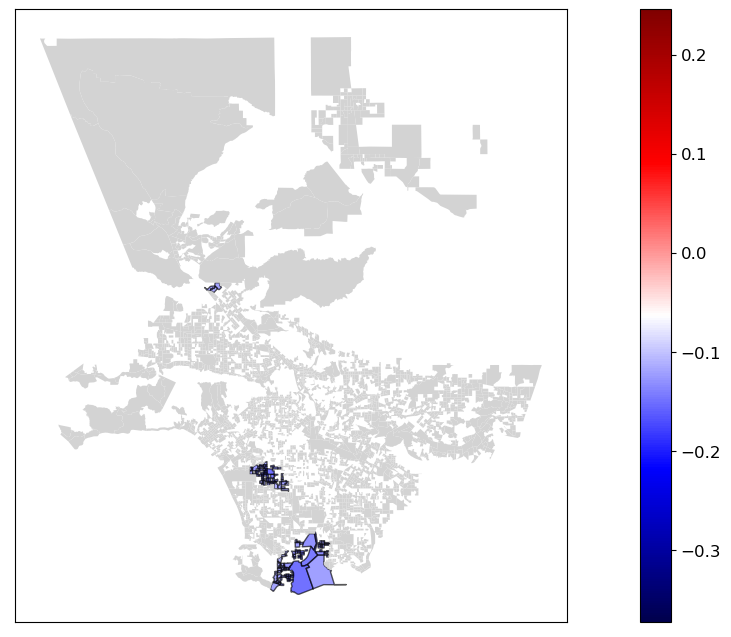

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
negative.plot(var1, cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#If there are insignificnt parameters plot gray polygons over them
if (gdf_LA[t1] == 0).any():
    gdf_LA[gdf_LA[t1] == 0].plot(color='lightgrey', ax=ax)

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [33]:
k = KeplerGl(data={'h':positive}, height=700) 
with open('config/visit_entropy.py', 'r') as config_file:
    k.config = json.loads(config_file.read())
k

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4gb7yr', 'type': '…